##  ABOUT PROJECT
This project has a dataset about animals. This dataset has 50 different types of animals such as antelope, buffalo and cow. My project goals forecasting some types of the animals using CNN(Convolutional Neural Network).

## IMPORTING NECESSARY LIBRARIES
* **Numpy**: Linear algebra operations
* **Pandas**: Data manipulations
* **Cv2**: Some image properties such as resizing
* **Os**: Directory operations
* **Matplotlib**: Visualizing
* **Seaborn**: Visualizing
* **Sklearn**: Splitting data into train and test and analyzing model success using some metrics
* **Tensorflow**: Image processing processes, preparing model layers and preventing overfitting

In [1]:
import numpy as np # Linear algebra
import pandas as pd # Data manipulation
import cv2 # Some image properties such as resizing
import os # Directory processing
import matplotlib.pyplot as plt # Visualizing
import seaborn as sns # Visualizing
from sklearn.model_selection import train_test_split # Splitting the data into train and test
from sklearn.metrics import confusion_matrix, classification_report # Analyzing model success
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Data Augmentation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Input, Dense, Dropout, BatchNormalization # Preparing layers
from tensorflow.keras import regularizers # Preventing overfitting
from tensorflow.keras.optimizers import Adam # Controlling the model parameters to increase the success
from tensorflow.keras.callbacks import EarlyStopping # Preventing overfitting


## PREPARING DATA
* By  this code block, I have just used 10 types of animals, that are collie, dolphin, elephant, fox, moose, rabbit, sheep, squirrel, giant+panda and polar+bear, from inside the data,  taken 650 images per each type and stored these images in a new directory.
* After that, I have created two lists named labels and images, then added class names into labels list and resized and normalized images into images list. 

In [2]:
source_filepath = "/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages"
record_filepath = "/kaggle/working/SelectedImages"

selected_species = ["collie", "dolphin", "elephant", "fox",
                  "moose", "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]
image_numbers_per_specy = 650

os.makedirs(record_filepath, exist_ok=True)

for specy_name in selected_species:
    class_path = os.path.join(source_filepath, specy_name)
    target_path = os.path.join(record_filepath, specy_name)
    os.makedirs(target_path, exist_ok=True)
    for i, file_name in enumerate(os.listdir(class_path)):
        if i >= 650:
            break
        full_file_name = os.path.join(class_path, file_name)
        if os.path.isfile(full_file_name):
            cv2.imwrite(os.path.join(target_path,file_name), cv2.imread(full_file_name))


In [3]:
def resizing_and_normalizing_images(file_path, image_size = (64,64)):
    labels = []
    images = []
    for class_name in os.listdir(file_path):
        class_path = os.path.join(file_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, image_size)
                    img = img / 255.0
                    labels.append(class_name)
                    images.append(img)

    return np.array(labels), np.array(images)
labels, images = resizing_and_normalizing_images(record_filepath)

## ENCODING PROCESSES
* **LabelEncoder**: Label Encoding is a technique used to convert categorical labels into numeric format. Each unique category in a dataset is assigned a unique integer value, enabling machine learning models to process and analyze categorical data.
* **to_categorical**: This function is used to convert integer labels into one-hot encoded format. Each label is represented as a binary vector where the index corresponding to the label is set to 1, and all other indices are set to 0. This format is commonly used in classification tasks for neural networks.

In [4]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

## SPLITTING DATA INTO TRAIN AND TEST

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, shuffle=True, test_size=0.2, random_state=42, stratify=labels_categorical)

In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5200, 64, 64, 3)
(1300, 64, 64, 3)
(5200, 10)
(1300, 10)


## DATA AUGMENTATION
* **rotation_range=30**: Randomly rotates images within 30 degrees.
* **width_shift_range=0.2**: Randomly shifts images horizontally by 20% of their width.
* **height_shift_range=0.2**: Randomly shifts images vertically by 20% of their height.
* **validation_split=0.2**: Reserves 20% of the data for validation during training.
* **horizontal_flip=True**: Randomly flips the input images horizontally (left to right) during training.
* **train_generator.fit(X_train)**: This method is used to compute statistics (such as mean and standard deviation) from the training data, X_train, for data normalization. It is typically applied when using a data generator (e.g., ImageDataGenerator) with feature-wise normalization enabled.

In [7]:
train_generator = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)
train_generator.fit(X_train) 

## PREPARING DATA FOR FITTING THE MODEL

In [8]:
train_images = train_generator.flow(
    X_train,
    y_train,
    batch_size=32,
    shuffle=True
)
val_images= train_generator.flow(
    X_train,
    y_train,
    batch_size=32,
    shuffle=True
)


## PREPARING LAYERS
* In this project, I have used 1 input layer, 3 convolution layers, 3 pooling layers, 1 flatten layer, 2 hidden layers, 2 dropout layers and and 1 output layer.
* Input Layer: It just defines the size of the images.
* First Convolution Layer: It has 64 filters, (3,3) kernel size, relu activation function and padding parameter.
* First Pooling Layer: It has (2,2) pool size.
* Second Convolution Layer: It has 128 filters, (3,3) kernel size, relu activation function and padding parameter.
* Second Pooling Layer: It has (2,2) pool size.
* Third Convolution Layer: It has 256 filters, (3,3) kernel size, relu activation function and padding parameter.
* Third Pooling Layer: It has (2,2) pool size.
* Flatten: It is used to convert a multi-dimensional tensor (e.g., 2D feature maps) into a 1D vector. This is typically done before passing the data into dense (fully connected) layers in a neural network.
* First Hidden Layer: It has 256 neurons, relu activation function and l2 regularizer to prevent overfitting.
* Second Hidden Layer: It has 128 neurons, relu activation function and l2 regularizer to prevent overfitting.
* Output Layer: It has 10 neurons,because of that we have just 10 types of animals, and softmax activation function.

In [9]:
from tensorflow.keras.models import Sequential
model = Sequential([
    Input(shape=(64,64,3)),
    
    Conv2D(64,kernel_size= (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128,kernel_size= (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256,kernel_size= (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu',kernel_regularizer=regularizers.l2),
    Dropout(0.2),
    
    Dense(128, activation='relu',kernel_regularizer=regularizers.l2),
    Dropout(0.2),
    
    Dense(10, activation='softmax') 
])

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,599,562 (17.55 MB)

 Trainable params: 4,599,562 (17.55 MB)

 Non-trainable params: 0 (0.00 B)

## PROCESS OF PREPARING MODEL
* **early_stopping**: Early stopping is a technique used during neural network training to stop the process when the model's performance on the validation data stops improving. It prevents overfitting by halting training before the model starts to memorize the training data.
    * monitor="val_loss": Monitors the validation loss during training.
    * patience=10: Waits for 10 epochs without improvement before stopping the training.
    * restore_best_weights=True: After stopping, restores the model weights to those of the epoch with the best validation loss.
* **Adam**: It (short for Adaptive Moment Estimation) is an optimization algorithm commonly used in training neural networks. It combines the benefits of two other optimizers:
    * Momentum: Helps accelerate convergence by using past gradients to smooth updates.
    * RMSProp: Adapts learning rates for each parameter based on the recent magnitude of gradients.
    * Key features:
        * Adjusts learning rates dynamically for each parameter.
        * Requires minimal tuning of hyperparameters.
        * Efficient and widely used for deep learning tasks.

In [11]:
from tensorflow.keras.callbacks import LearningRateScheduler
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)
lr_scheduler = LearningRateScheduler(lambda epoch: 0.001 * (0.1 ** (epoch // 10)))
optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

## FITTING MODEL
This code trains a neural network using the fit method and includes key parameters for training:
* **train_images**: The training data fed into the model.
* **epochs=70**: The maximum number of training cycles (epochs) the model will run.
* **batch_size=32**: The model processes 32 samples at a time before updating the weights.
* **validation_data=val_images**: The validation dataset to evaluate the model's performance after each epoch.
* **callbacks=[early_stopping]**: The EarlyStopping callback stops training if validation performance doesn't improve after a set number of epochs (e.g., patience).
* The result (result) stores the training history, including metrics like loss and accuracy for both training and validation sets.

In [12]:
result = model.fit(
    train_images,
    epochs = 70,
    batch_size = 32,
    validation_data=val_images,
    callbacks = [early_stopping]
)

Epoch 1/70


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 100ms/step - accuracy: 0.1616 - loss: 4.0386 - val_accuracy: 0.2179 - val_loss: 2.2013
Epoch 2/70
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.2197 - loss: 2.1600 - val_accuracy: 0.2515 - val_loss: 2.0848
Epoch 3/70
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.2687 - loss: 2.0576 - val_accuracy: 0.3152 - val_loss: 1.9873
Epoch 4/70
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.3200 - loss: 1.9712 - val_accuracy: 0.3635 - val_loss: 1.8586
Epoch 5/70
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.3675 - loss: 1.8579 - val_accuracy: 0.4029 - val_loss: 1.7716
Epoch 6/70
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.3945 - loss: 1.7986 - val_accuracy: 0.4233 - val_loss: 1.7382
Epoch 7/70
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.3933 - loss: 1.7815 - val_accuracy: 0.4423 - val_loss: 1.6691
Epoch 8/70
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.4271 - loss: 1.7298 - val_accura

## VISUALIZING RESULTS

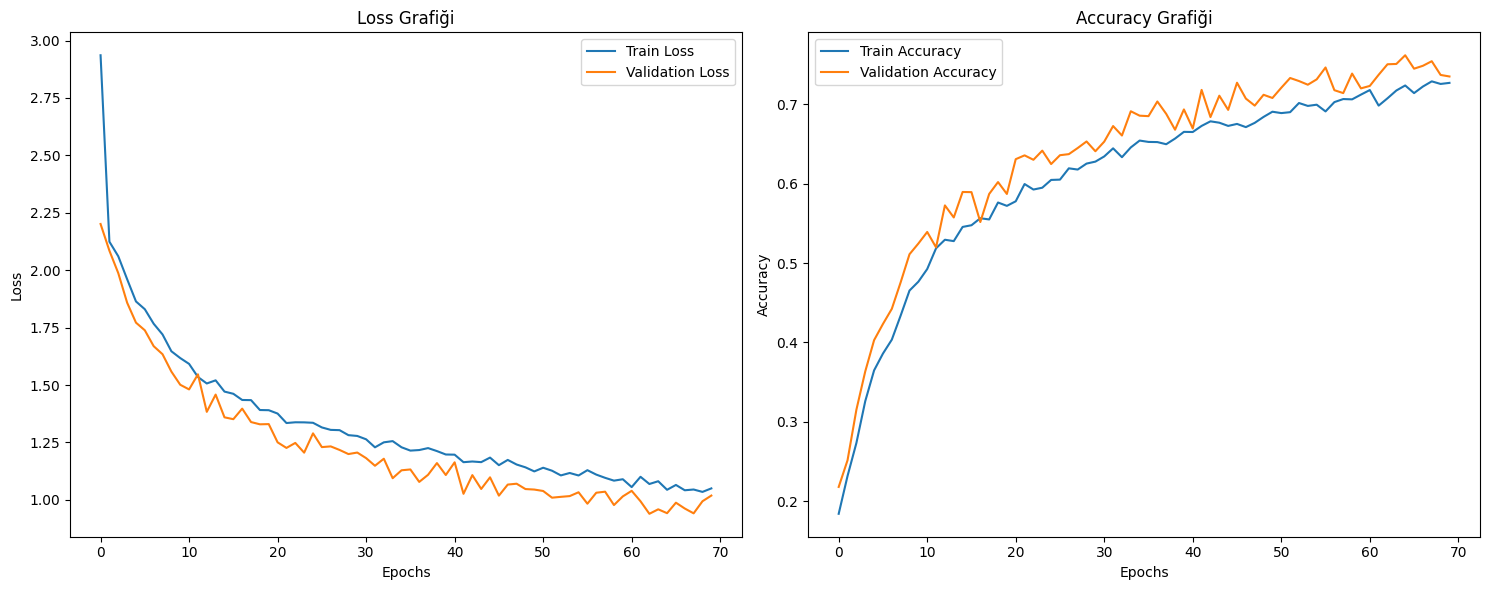

In [13]:
plt.figure(figsize=(15, 6))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(result.history['loss'], label='Train Loss')
plt.plot(result.history['val_loss'], label='Validation Loss')
plt.title('Loss Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(result.history['accuracy'], label='Train Accuracy')
plt.plot(result.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## CONTROLLING MODEL SUCCESS WITH TEST IMAGES 

In [14]:
def control_accuracy_with_test_images(title, test_data):
    print(f"\n{title} Information")
    y_pred = model.predict(test_data)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test,axis=1)
    loss, accuracy = model.evaluate(test_data, y_test)
    
    #Confusion matrix
    from sklearn.metrics import confusion_matrix
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
    plt.xlabel(f'{title} Predicted')
    plt.ylabel(f'{title} True')
    plt.title(f'{title} Confusion Matrix ')
    plt.show()

    return loss, accuracy


Standart X test Information
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7450 - loss: 0.9990


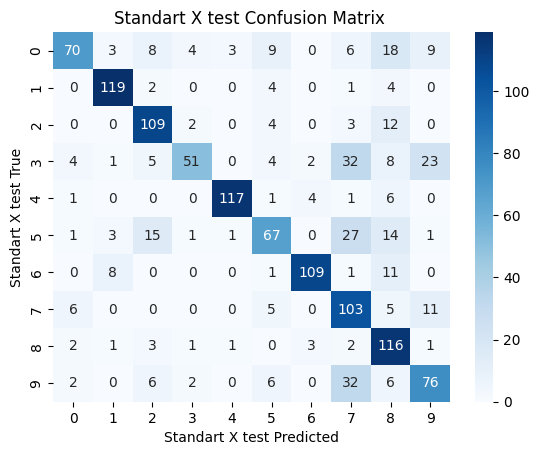

In [15]:
loss_X_test, accuracy_X_test = control_accuracy_with_test_images("Standart X test", X_test)

## IMAGE MANIPULATION WITH PURPLE, YELLOW AND GREEN FILTERS

In [16]:
def linearize_image(image):
    """
    Converts an sRGB image to linear RGB assuming the input image is in the range [0, 1]
    """
    return np.where(image <= 0.04045,
                    image / 12.92,
                    ((image + 0.055) / 1.055) ** 2.4)

def linear_to_srgb(image):
    """
    Converts a linear RGB image to sRGB assuming the input image is in the range [0, 1]
    """
    return np.where(image <= 0.0031308,
                    image * 12.92,
                    1.055 * (image ** (1 / 2.4)) - 0.055)
    
def manipulate_light_source(image, light_color):
    """
    Simulates color manipulation under a different light source

    Args:
    - image: The input image (sRGB, [0, 1])
    - light_color: The light source color (unit norm RGB vector)

    Returns:
    - Manipulated image (sRGB, [0, 1])
    """
    # Step 1: Linearize the image
    linear_image = linearize_image(image)

    # Step 2: Apply the light source (multiplying the linear image by the light color)
    manipulated_image = linear_image * light_color

    # Step 3: Convert the manipulated image back to sRGB
    manipulated_srgb = linear_to_srgb(manipulated_image)

    return np.clip(manipulated_srgb, 0, 1) 
    
def get_light_sources():
    """
    Returns a set of light sources for image manipulation
    """
    purplish_light = np.array([0.82, 0.15, 0.89]) / np.linalg.norm([0.82, 0.15, 0.89])
    yellowish_light = np.array([0.96, 0.24, 0.11]) / np.linalg.norm([0.96, 0.24, 0.11])
    greenish_light = np.array([0.11, 0.98, 0.12]) / np.linalg.norm([0.11, 0.98, 0.12])
    return purplish_light, yellowish_light, greenish_light
    
def get_manipulated_images(image):
    """
    Get manipulated images by applying color vectors
    """
    
    # Get the color vectors
    purplish_light, yellowish_light, greenish_light = get_light_sources()

    # Manipulate the images under different light sources
    manipulated_purplish = manipulate_light_source(image, purplish_light)
    manipulated_yellowish = manipulate_light_source(image, yellowish_light)
    manipulated_greenish = manipulate_light_source(image, greenish_light)

    os.makedirs("/kaggle/working/Manipulated Images with Purplish", exist_ok=True)
    os.makedirs("/kaggle/working/Manipulated Images with Yellowish", exist_ok=True)
    os.makedirs("/kaggle/working/Manipulated Images with Greenish", exist_ok=True)
    # Save the manipulated images
    cv2.imwrite('/kaggle/working/Manipulated Images with Purplish/manipulated_purplish.jpg', cv2.cvtColor((manipulated_purplish*255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    cv2.imwrite('/kaggle/working/Manipulated Images with Yellowish/manipulated_yellowish.jpg', cv2.cvtColor((manipulated_yellowish*255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    cv2.imwrite('/kaggle/working/Manipulated Images with Greenish/manipulated_greenish.jpg', cv2.cvtColor((manipulated_greenish*255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    return manipulated_purplish, manipulated_yellowish, manipulated_greenish

In [17]:
purplish_X_test = []
yellowish_X_test = []
greenish_X_test = []
for image in X_test:
    purplish_image, yellowish_image, greenish_image = get_manipulated_images(image)
    purplish_X_test.append(purplish_image)
    yellowish_X_test.append(yellowish_image)
    greenish_X_test.append(greenish_image)
    
purplish_X_test = np.array(purplish_X_test)
yellowish_X_test = np.array(yellowish_X_test)
greenish_X_test = np.array(greenish_X_test)

## CONTROLLING MODEL SUCCESS WITH MANIPULATED TEST IMAGES


Purplish X test Information
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1690 - loss: 5.0240


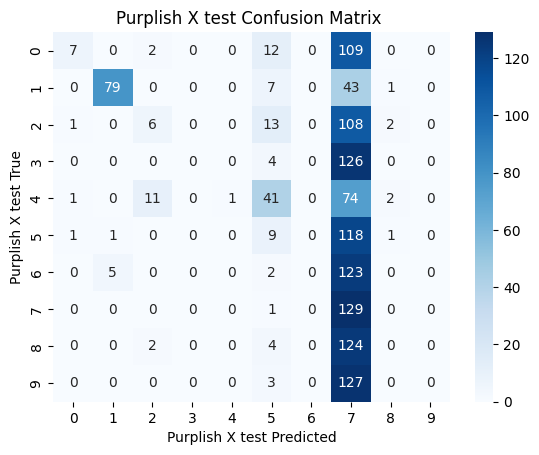


Yellowish X test Information
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1408 - loss: 4.9213


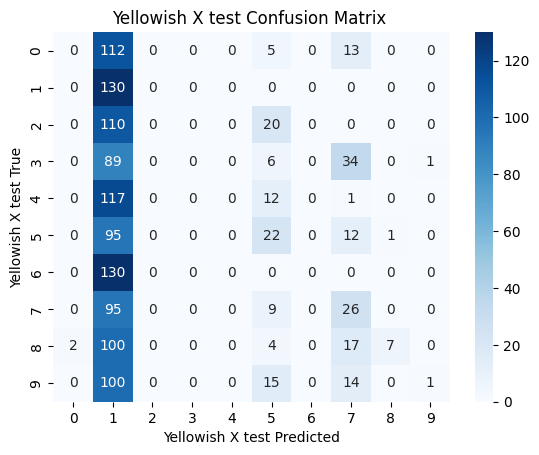


Greenish X test Information
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1098 - loss: 4.9092


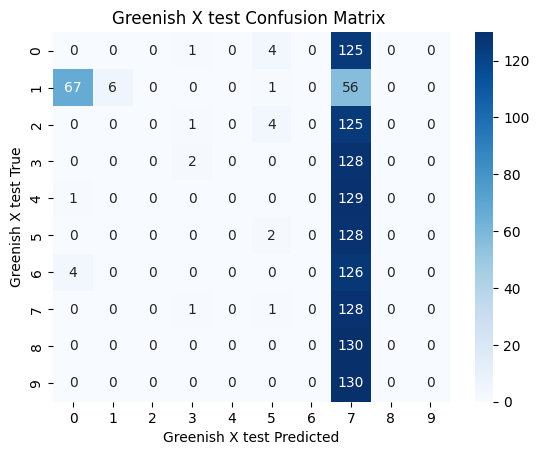

In [18]:
loss_purplish, accuracy_purplish = control_accuracy_with_test_images("Purplish X test", purplish_X_test)
loss_yellowish, accuracy_yellowish = control_accuracy_with_test_images("Yellowish X test", yellowish_X_test)
loss_greenish, accuracy_greenish = control_accuracy_with_test_images("Greenish X test", greenish_X_test)

In [19]:
"""
def apply_gray_world(image):
    '''
    Grey World renk sabitliği algoritmasını bir görüntüye uygular.

    Args:
        image_path (str): Giriş görüntüsünün dosya yolu.

    Returns:
        numpy.ndarray: Renk sabitliği uygulanmış görüntü.
    '''

    # BGR kanallarını ayır
    B, G, R = cv2.split(image)

    # Her kanal için ortalama parlaklık değerini hesapla
    mean_B = np.mean(B)
    mean_G = np.mean(G)
    mean_R = np.mean(R)

    # Ortalama parlaklıklar
    mean_gray = (mean_B + mean_G + mean_R) / 3

    # Ölçek faktörleri hesapla
    scale_B = mean_gray / mean_B
    scale_G = mean_gray / mean_G
    scale_R = mean_gray / mean_R

    # Her kanalı ölçeklendir
    B = cv2.multiply(B, scale_B)
    G = cv2.multiply(G, scale_G)
    R = cv2.multiply(R, scale_R)

    # Kanalları birleştir
    balanced_image = cv2.merge((B, G, R))

    # Değerleri 0-255 arasında tut
    balanced_image = np.clip(balanced_image, 0, 255).astype(np.uint8)

    return balanced_image
"""

"\ndef apply_gray_world(image):\n    '''\n    Grey World renk sabitliği algoritmasını bir görüntüye uygular.\n\n    Args:\n        image_path (str): Giriş görüntüsünün dosya yolu.\n\n    Returns:\n        numpy.ndarray: Renk sabitliği uygulanmış görüntü.\n    '''\n\n    # BGR kanallarını ayır\n    B, G, R = cv2.split(image)\n\n    # Her kanal için ortalama parlaklık değerini hesapla\n    mean_B = np.mean(B)\n    mean_G = np.mean(G)\n    mean_R = np.mean(R)\n\n    # Ortalama parlaklıklar\n    mean_gray = (mean_B + mean_G + mean_R) / 3\n\n    # Ölçek faktörleri hesapla\n    scale_B = mean_gray / mean_B\n    scale_G = mean_gray / mean_G\n    scale_R = mean_gray / mean_R\n\n    # Her kanalı ölçeklendir\n    B = cv2.multiply(B, scale_B)\n    G = cv2.multiply(G, scale_G)\n    R = cv2.multiply(R, scale_R)\n\n    # Kanalları birleştir\n    balanced_image = cv2.merge((B, G, R))\n\n    # Değerleri 0-255 arasında tut\n    balanced_image = np.clip(balanced_image, 0, 255).astype(np.uint8)\n\n    re

## APPLYING GRAY WORLD ALGORITHM TO MANIPULATED TEST IMAGES

In [20]:
def apply_gray_world(image):
    avg_b, avg_g, avg_r = cv2.mean(image)[:3]
    gray_value = (avg_b + avg_g + avg_r) / 3
    scaling_factors = np.array([gray_value / avg_b, gray_value / avg_g, gray_value / avg_r])
    corrected_image = image * scaling_factors  # Her kanal için ayrı ölçekleme
    corrected_image = np.clip(corrected_image, 0, 255).astype(np.uint8)
    return corrected_image

In [21]:
corrected_purplish_images = np.array([apply_gray_world(image) for image in purplish_X_test])
corrected_yellowish_images = np.array([apply_gray_world(image) for image in yellowish_X_test])
corrected_greenish_images = np.array([apply_gray_world(image) for image in greenish_X_test])

## CONTROLLING MODEL SUCCESS WITH CORRECTED TEST IMAGES


Corrected Purplish X_test Information
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1058 - loss: 3.1826


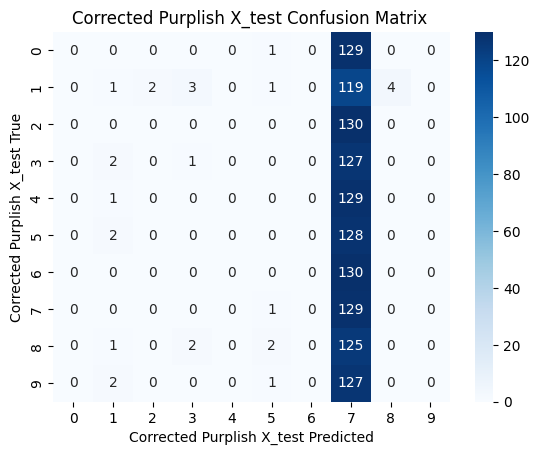


Corrected Yellowish X_test Information
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1065 - loss: 3.1725


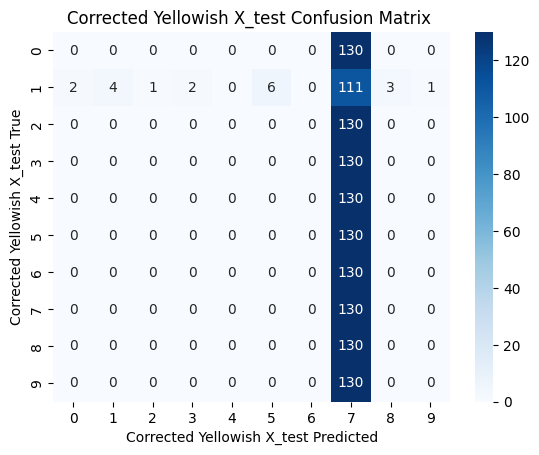


Corrected Greenish X_test Information
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1028 - loss: 3.2040


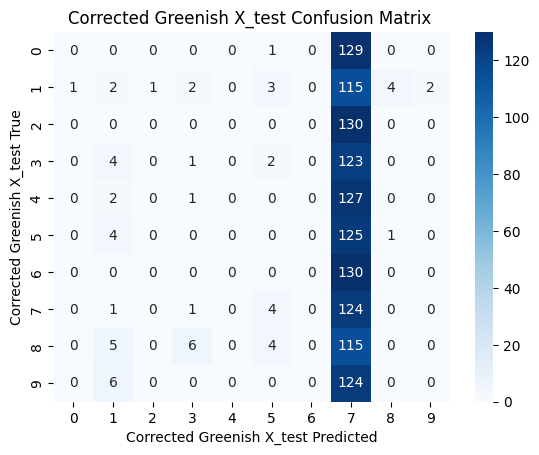

In [22]:
loss_corrected_purplish, accuracy_corrected_purplish = control_accuracy_with_test_images("Corrected Purplish X_test", corrected_purplish_images)
loss_corrected_yellowish, accuracy_corrected_yellowish = control_accuracy_with_test_images("Corrected Yellowish X_test", corrected_yellowish_images)
loss_corrected_greenish, accuracy_corrected_greenish = control_accuracy_with_test_images("Corrected Greenish X_test", corrected_greenish_images)

## COMPARING RESULTS

In [23]:
X_tests = ["Standart X test","Purplish X test","Yellowish X test","Greenish X test","Corrected Purplish X_test", "Corrected Yellowish X_test","Corrected Greenish X_test"]
Losses = [loss_X_test,loss_purplish,loss_yellowish,loss_greenish,loss_corrected_purplish,loss_corrected_yellowish,loss_corrected_greenish]
Accuracies = [accuracy_X_test,accuracy_purplish,accuracy_yellowish, accuracy_greenish, accuracy_corrected_purplish,accuracy_corrected_yellowish,accuracy_corrected_greenish]

result_dataFrame = pd.DataFrame(columns=["X_test","Loss","Accuracy"])
result_dataFrame["X_test"] = X_tests
result_dataFrame["Loss"] = Losses
result_dataFrame["Accuracy"] = Accuracies
result_dataFrame

,X_test,Loss,Accuracy
0,Standart X test,1.029629,0.720769
1,Purplish X test,4.935631,0.177692
2,Yellowish X test,4.888004,0.143077
3,Greenish X test,4.905847,0.106154
4,Corrected Purplish X_test,3.213506,0.100769
5,Corrected Yellowish X_test,3.214121,0.103077
6,Corrected Greenish X_test,3.243316,0.097692
